### Prepare the Training Set

In [17]:
import numpy as np
import pandas as pd

#Load all training data
X_train = pd.read_csv('Inputs\\train_test_sets\\training.csv')
y_train = X_train.pop('Label')
print(X_train.shape)

(999856, 71)


In [19]:
from sklearn.calibration import LabelEncoder

#drop features that are not required
features_to_drop = ['Protocol', 'Dst Port Class']
X_train.drop(axis=1, columns=features_to_drop, inplace=True)

#Encode the target classes
labelEnc = LabelEncoder()
y_train = pd.Series(labelEnc.fit_transform(y_train), index=y_train.index)


In [20]:
from collections import Counter
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [35]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

#Define the over sampling and under sampling dictionaries
dictUnderSample = {  8: 60000,
                    4: 60000,
                    6: 60000,
                    1: 60000,
                    0: 60000,
                    11: 60000,
                    13: 60000,
                    7: 31131,
                    10: 29045,
                    9: 8243,
                    5: 1298,
                    2: 458,
                    3: 173,
                    12: 65}

dictOverSample = {  8: 60000,
                    4: 60000,
                    6: 60000,
                    1: 60000,
                    0: 60000,
                    11: 60000,
                    13: 60000,
                    7: 60000,
                    10: 60000,
                    9: 60000,
                    5: 60000,
                    2: 60000,
                    3: 60000,
                    12: 60000}

#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
print(len(X_train2))
y_train2.value_counts()

809045


0     60000
1     60000
2     60000
3     60000
4     60000
5     60000
6     60000
7     60000
8     60000
9     60000
11    60000
12    60000
13    60000
10    29045
Name: count, dtype: int64

In [22]:
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import StratifiedKFold

#Use GridSearch cross-validation to find optimum parameters
cv = StratifiedKFold(n_splits=4, shuffle=True)
f2_scorer = make_scorer(fbeta_score, beta=2, average='macro')

#Define Optune objective method
def objective(trial, X, y, cv, scoring):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 350, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3),
        #"num_leaves": trial.suggest_int("num_leaves", 50, 3000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "max_bin": trial.suggest_int("max_bin", 50, 450, step=50),
        "boosting_type": trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        # "max_bin": trial.suggest_int("max_bin", 200, 300),
        # "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        # "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        # "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        # "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        # "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        # "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1)
        "objective": 'multiclass', 
        "verbose": -1
        #"random_state": 0
    }

    clf = LGBMClassifier(**param_grid)
    cv_scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring, n_jobs=5)
    return cv_scores.mean()

#Initialise the Optuna study
study = optuna.create_study(direction="maximize", study_name='Hyperparameter Tuning')       #We want to maximise the F2 scores

#Optimization with several trials
func = lambda trial: objective(trial, X_train2, y_train2, cv=cv, scoring=f2_scorer)
study.optimize(func, n_trials=5)

#Output results
trial = study.best_trial
print("Best F2-macro score (mean): ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))


[I 2024-01-14 19:39:12,027] A new study created in memory with name: Hyperparameter Tuning
[I 2024-01-14 19:41:17,018] Trial 0 finished with value: 0.049480804075323945 and parameters: {'n_estimators': 150, 'learning_rate': 0.2998252949677568, 'max_depth': 8, 'max_bin': 200, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.049480804075323945.
[I 2024-01-14 19:47:15,878] Trial 1 finished with value: 0.7561607855291003 and parameters: {'n_estimators': 250, 'learning_rate': 0.2738660748949303, 'max_depth': 7, 'max_bin': 50, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.7561607855291003.
[I 2024-01-14 19:50:32,020] Trial 2 finished with value: 0.9791263896374838 and parameters: {'n_estimators': 150, 'learning_rate': 0.11856905648331888, 'max_depth': 5, 'max_bin': 200, 'boosting_type': 'dart'}. Best is trial 2 with value: 0.9791263896374838.
[I 2024-01-14 19:50:57,351] Trial 3 finished with value: 0.8367358490568826 and parameters: {'n_estimators': 50, 'learning_rate': 0.29

Best F2-macro score (mean):  0.979809336587408
Best Params: 
  n_estimators: 150
  learning_rate: 0.06581286845662779
  max_depth: 11
  max_bin: 400
  boosting_type: dart


In [23]:
optuna.visualization.plot_param_importances(study)

## Execute the model on Testing Set

In [39]:
from collections import Counter
Counter(y_train2)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [27]:
from CustomFunctions import Timer
clf = LGBMClassifier(boosting_type='dart', objective='multiclass', n_jobs=-1, verbose=-1, 
                     n_estimators=150, learning_rate=0.066, max_depth=11, max_bin=400 )

#First fit the model
t = Timer()
t.start()
clf.fit(X_train2, y_train2)
t.stop(timerName='Training of model')

Training of model took 66.83 seconds (758.08 CPU seconds)


In [30]:
from sklearn.calibration import LabelEncoder

#Load all testing data
X_test = pd.read_csv('Inputs\\train_test_sets\\testing.csv')
y_test = X_test.pop('Label')

#drop features that are not required
features_to_drop = ['Protocol', 'Dst Port Class']
X_test.drop(axis=1, columns=features_to_drop, inplace=True)

#Encode the target classes
labelEnc = LabelEncoder()
y_test = pd.Series(labelEnc.fit_transform(y_test), index=y_test.index)
print(X_test.shape)

(1499016, 69)


In [31]:
t = Timer()
t.start()
pred_test_1000 = clf.predict(X_test.head(1000))
t.stop('Executing model over the first 1000 rows of Testing Set')

#Obtain predictions on the full Training dataset
pred_train = clf.predict(X_train)

#Obtain predictions on the full Testing dataset
t.start()
pred_test = clf.predict(X_test)
t.stop('Executing model over the entire Testing set (' + str(len(X_test)) + ') rows')

Executing model over the first 1000 rows of Testing Set took 0.02 seconds (0.14 CPU seconds)
Executing model over the entire Testing set (1499016) rows took 15.19 seconds (164.16 CPU seconds)



Training Set: Size:  (999856, 69)
Training Set: F2 score:  0.9660808377527719
Training Set: Matthews Correlation Coefficient:  0.973242468587003

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.8543880150898867
Testing Set: Matthews Correlation Coefficient:  0.8999364661575133


    precision  recall  f2-score  support
0        1.00    0.87      0.90  847,255
1        1.00    1.00      1.00   71,548
2        0.26    0.93      0.62      153
3        0.24    0.93      0.58       57
4        1.00    1.00      1.00  171,503
5        0.70    0.99      0.92      432
6        1.00    1.00      1.00  144,048
7        1.00    1.00      1.00   10,377
8        1.00    1.00      1.00  115,478
9        0.98    1.00      1.00    2,747
10       1.00    1.00      1.00   48,339
11       0.26    0.92      0.61   40,160
12       0.10    0.86      0.34       22
13       1.00    1.00      1.00   46,897

Matthews Correlation Coefficient:  0.90
F2 Macro score:  85.4%


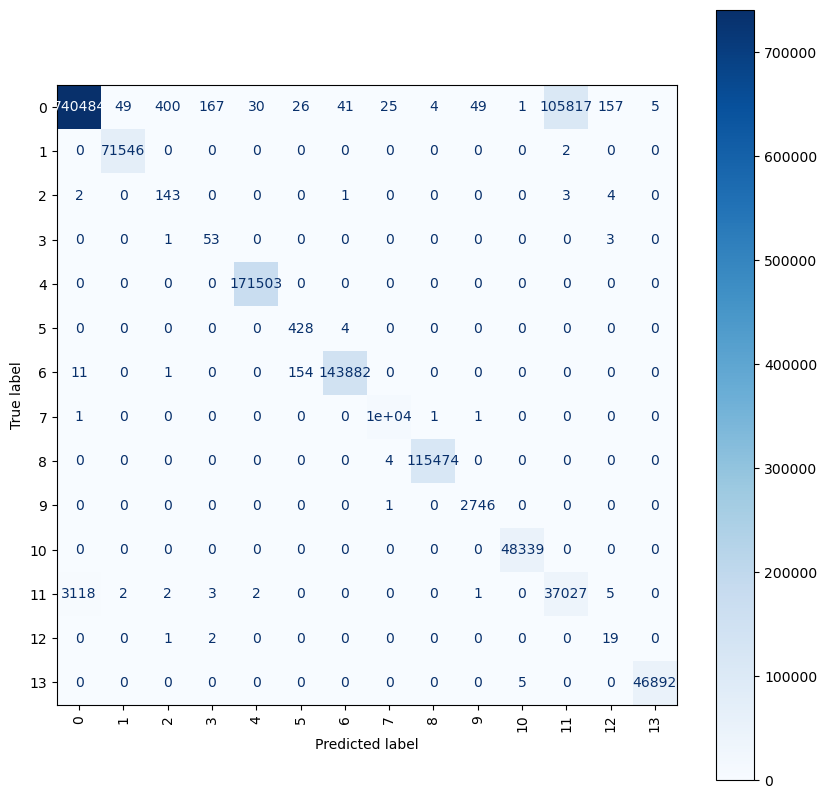

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from CustomFunctions import classification_report_IDS

#Output results
print('\nTraining Set: Size: ', X_train.shape)
print('Training Set: F2 score: ', fbeta_score(y_train, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')

#Plot the confusion matrix
c = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_test), display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10,10))
c.plot(ax = ax, cmap='Blues', xticks_rotation='vertical')

## Classification Report
classification_report_IDS(y_test, pred_test)

#### What is the optimum Training Set size?

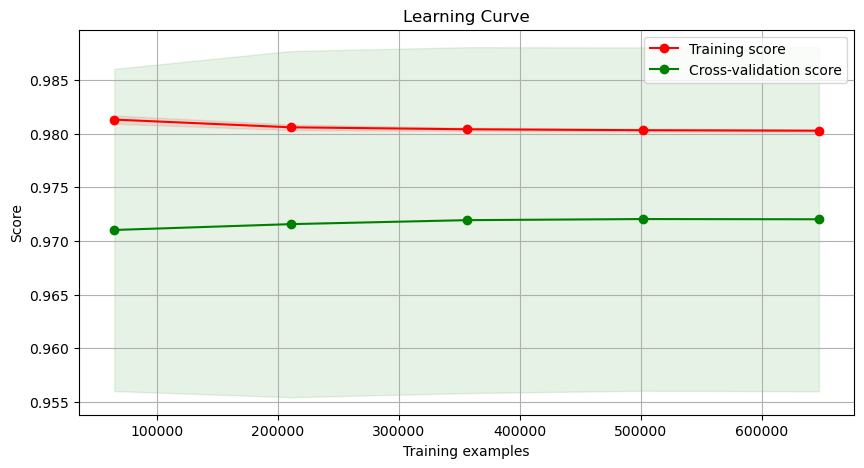

In [38]:
from plot_Validation_and_LearningCurves import plot_learning_curve, plot_validation_curve
from sklearn import metrics
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)
f2_scorer = make_scorer(fbeta_score, beta=2, average='macro')
plot_learning_curve(clf, X=X_train2, y=y_train2, cv=cv, scoring=f2_scorer, train_sizes=np.linspace(0.1, 1.0, 5));


**Observations:** The above Learning Curve seems to be ideal as both the training and validation curves are producing very high F2 scores while the gap between them is only 1% - indicating there is relatively low overfitting. Also, a good training set size would be around 500,000